<a href="https://colab.research.google.com/github/fardil-b/DL-PyTorch/blob/main/CPU_to_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CPU to GPU

GPUs, or graphical processing units, are not replacement for CPU architecture, rather they're powerful accelerators for existing infrastructure. GPU accelerate computing, offloads compute intensive portions of the applications to the GPU, while the remainder of the code still runs on the CPU. One way to think of it is CPUs are for general purpose computing and GPUs are great for intensive computational calculations such as matrix multiplication which we use as part of training a neural network. 

**CUDA** is a parallel computing platform and programming model developed by NVIDIA for general computing with its own GPUs. 

When using GPUs, there are three things you want to do. 

  1. At the top of the notebook, specify the CUDA device. 
  2. you want to do a transfer from the neural network to the GPU. 
  3. you want to send all of the inputs and the targets to the GPU.

In [2]:
# Setting seeds to try and ensure we have the same results - this is not guaranteed across PyTorch releases.
import torch
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

import numpy as np
np.random.seed(0)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


Google Colab gives us access to a GPU for free.

Two way to use gpu in google colab
  1. Edit- notebook settings -> change Hardware accelerator to GPU
  2. Runtime -> change runtime type -> change Hardware accelerator to GPU


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch import nn

mean, std = (0.5,), (0.5,)

# Create a transform and normalise data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean, std)
                              ])

# Download FMNIST training dataset and load training data
trainset = datasets.FashionMNIST('~/.pytorch/FMNIST/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download FMNIST test dataset and load test data
testset = datasets.FashionMNIST('~/.pytorch/FMNIST/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

Extracting /root/.pytorch/FMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/FMNIST/FashionMNIST/raw


Extracting /root/.pytorch/FMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/FMNIST/FashionMNIST/raw


Extracting /root/.pytorch/FMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/FMNIST/FashionMNIST/raw




Extracting /root/.pytorch/FMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/FMNIST/FashionMNIST/raw
Processing...


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


In [5]:
class FMNIST(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(784, 128)
    self.fc2 = nn.Linear(128,64)
    self.fc3 = nn.Linear(64,10)
    
  def forward(self, x):
    x = x.view(x.shape[0], -1)
    
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    x = F.log_softmax(x, dim=1)
    
    return x

model = FMNIST()

Moving your model from CPU memory to GPU memory. These methods will recursively go over all the modules and convert their parameters and buffers to CUDA Tensor. 

In [7]:
model.to(device)

FMNIST(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

Now because I've sent my model to GPU memory, I also need to send the inputs and the targets at every step to the GPU too. So you load the images and labels from the trainloader and send them to GPU memory.

In [8]:
from torch import optim
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

num_epochs = 3

for i in range(num_epochs):
    cum_loss = 0
    
    for images, labels in trainloader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        cum_loss += loss.item()
     
    print(f"Training loss: {cum_loss/len(trainloader)}")

Training loss: 1.0321013938262265
Training loss: 0.5614258848718489
Training loss: 0.4915215881553286


when training, we want to be using GPU memory. When testing, we want to be using the CPUs, so we'll need to copy the model over from the GPU memory to the CPU. We don't need to do anything to the inputs, as the testloader is by default on CPU memory, so what we did in the training step was to take the training images and labels and then move them across to the GPU memory. In the real world you'll find that we train on GPUs, but when it comes to deploying the model, say on a CCTV camera, then having a GPU is too expensive and so we normally have a CPU and we run our model on that.

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

images, labels = next(iter(testloader))

test_image_id = 0 
img = images[test_image_id].view(1, 784) 

model.to('cpu') # move the model back to CPU memory.
with torch.no_grad():
    logps = model(img)

In [11]:
ps = torch.exp(logps)
ps

tensor([[2.6551e-06, 7.3304e-07, 1.0533e-05, 2.9520e-06, 9.4441e-06, 1.3640e-01,
         6.7577e-06, 4.1222e-01, 9.5907e-03, 4.4176e-01]])

In [12]:
nps = ps.numpy()[0]
nps

array([2.6550972e-06, 7.3303534e-07, 1.0532536e-05, 2.9519808e-06,
       9.4441139e-06, 1.3640194e-01, 6.7576671e-06, 4.1221827e-01,
       9.5907105e-03, 4.4175604e-01], dtype=float32)

<BarContainer object of 10 artists>

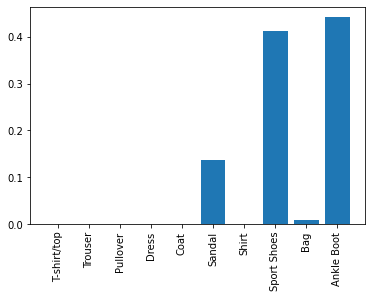

In [13]:
FMNIST_labels = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sport Shoes','Bag','Ankle Boot']
plt.xticks(np.arange(10),labels=FMNIST_labels,rotation='vertical')
plt.bar(np.arange(10), nps)

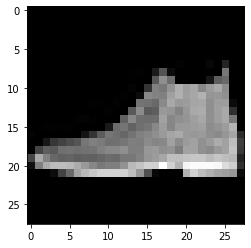

In [14]:
def denormalize(tensor):
  tensor = tensor*0.5 + 0.5
  return tensor
  
img = img.view(28,-1)
img = denormalize(img)
plt.imshow(img,cmap='gray')

 So I'm going to transfer my model back to GPU memory

In [15]:
model.to(device)

FMNIST(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

images, labels = next(iter(testloader))

test_image_id = 0 
img = images[test_image_id].view(1, 784) 

# model.to('cpu') # move the model back to CPU memory.
with torch.no_grad():
    logps = model(img)

RuntimeError: ignored

 You get an error message that says runtime error, expected object of backend CUDA but got backend CPU for argument. This is because your model is on GPU memory but your inputs and labels are on CPU memory, so it's really important to remember to keep both your models and your inputs on the same type of memory